# Bayesian modeling for the detection of adverse events underreporting in clinical trials

This is the companion notebook of a paper by Y. Barmaz and T. Ménard on a statistical method for the detection of adverse event underreporting from clinical trial investigator sites.

In [1]:
import pandas as pd
import numpy as np
import random
import pymc3 as pm
import arviz as az

import seaborn as sns
import matplotlib.pyplot as plt

RANDOM_SEED = 123

In [2]:
data = pd.read_csv('ae_data.csv')
data.head(5)

,study,site_number,patnum,ae_count_cumulative
0,NCT00617669,3001,16,4
1,NCT00617669,3001,456,1
2,NCT00617669,3002,171,2
3,NCT00617669,3002,248,2
4,NCT00617669,3002,304,1


In [3]:
# Helper functions and data to visualize AE counts frequencies and their predicted values

df_obs = (data
          .groupby('ae_count_cumulative')[['patnum']]
          .count()
          .reset_index()
          .rename({'patnum': 'observed', 'ae_count_cumulative': 'ae_count'}, axis=1)
          .assign(norm_observed=lambda x: x.observed/x.observed.sum())
         )

df_obs = (pd.DataFrame({'ae_count': range(50)})
          .merge(df_obs.reset_index(drop=True), how='left')
          .fillna(0)
          .assign(observed=lambda x: x.observed.astype(int))
         )

def format_barplot(ax):
    ax.xaxis.set_major_locator(plt.MultipleLocator(10))
    ax.xaxis.set_minor_locator(plt.MultipleLocator(10))
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, tick: int(x)))
    return ax
    
def plot_observed_ae_frequencies():
    ax = format_barplot(sns.barplot(x='ae_count', y='norm_observed', data=df_obs))
    ax.set_title('Observed AE count frequencies')
    plt.show()
    
def plot_predicted_ae_frequencies(predicted_checks, prefix=''):
    ae_values, prior_counts =np.unique(predicted_checks['observations'].flatten().astype(int), return_counts=True)
    df_prior_obs = df_obs.merge(pd.DataFrame({'ae_count': ae_values,
                                              'prior': prior_counts,
                                              'norm_prior': prior_counts/prior_counts.sum()}),
                                how='left')

    ax = format_barplot(sns.barplot(x='ae_count', y='norm_prior', data=df_prior_obs))
    ax.set_title(prefix + ' predicted AE count frequencies')
    plt.show()

In [4]:
sites = data['site_number'].values
observed_ae = data['ae_count_cumulative'].values

unique_sites, sites_idx = np.unique(sites, return_inverse=True)

## Model with exponential priors

The (observed) count of adverse events reported by the $n_i$ patients of site $i$ are modeled with a Poisson distribution, $Y_i \sim \mathrm{Poi}(\lambda_i)$. The $N_{\mathrm{sites}}$ Poisson rates $\lambda_i$ are in turn modeled as realizations of a random variable unique to the whole study with Gamma distribution $\Gamma(\mu, \sigma)$. The parameters $\mu$ and $\sigma$ are unknown, so we assume a vague prior for both of them, $\mu \sim \mathrm{Exp}(0.1)$ and $\sigma \sim \mathrm{Exp}(0.1)$. The full joint distribution
$$
P(\mu, \sigma, \lambda_i, Y_{i,j}) = P(\mu)P(\sigma)\prod_{i=1}^{N_{\mathrm{sites}}}P(\lambda_i\vert\mu,\sigma)\prod_{j=1}^{n_i} P(Y_{i,j}\vert \lambda_i)
$$
is coded in the following PyMC3 model:

In [41]:
with pm.Model() as model:
    mu = pm.Exponential("mu", lam=0.1)
    sigma = pm.Exponential("sigma", lam=0.1)
    
    rates = pm.Gamma("rates", mu=mu, sigma=sigma, shape=unique_sites.shape)
    observations = pm.Poisson("observations", mu=rates[sites_idx], observed=observed_ae)
    
    # sample a reference rate from the study-level distribution and use it to estimate
    # the tail area of the inferred site rates:
    reference_rate = pm.Gamma("reference_rate", mu=mu, sigma=sigma)
    underreporting = pm.Deterministic("underreporting", reference_rate < rates)
    
    prior_checks = pm.sample_prior_predictive(samples=50, random_seed=RANDOM_SEED)

/Users/barmazy/opt/anaconda3/lib/python3.7/site-packages/pymc3/distributions/transforms.py:221: RuntimeWarning: divide by zero encountered in log
  return np.log(x)


### Prior predictive check
The validity of the hyperprior parameters can be verified with a sample of AE counts from the prior distribution:

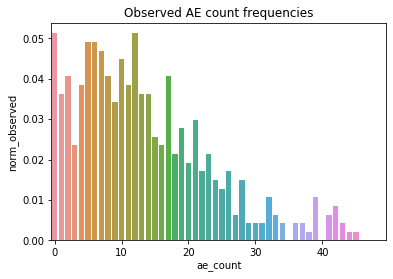

In [42]:
plot_observed_ae_frequencies()

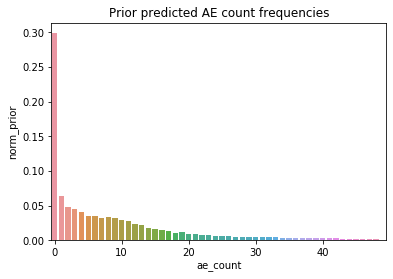

In [43]:
plot_predicted_ae_frequencies(prior_checks, "Prior")

### MCMC inference

In [44]:
with model:
    idata = pm.sample(5000, return_inferencedata=True, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [reference_rate, rates, sigma, mu]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 34 seconds.


### Convergence assessment

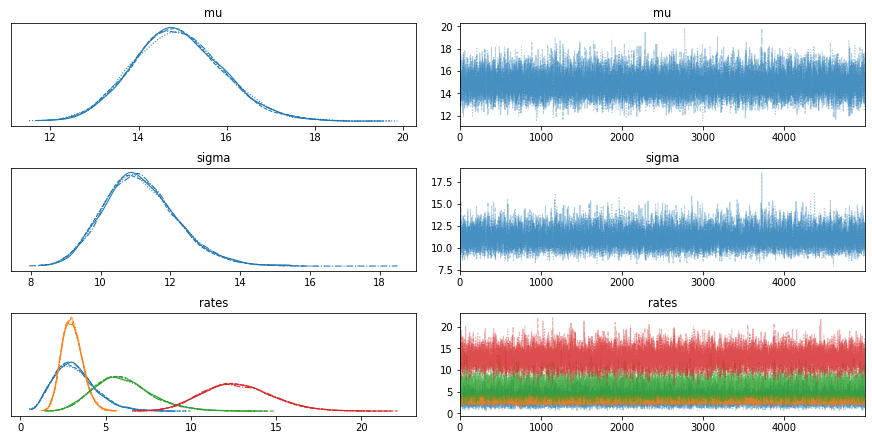

In [45]:
pm.plot_trace(idata, var_names=["mu", "sigma", "rates"], coords={"rates_dim_0": [0, 1, 2, 3]})
plt.show()

In [46]:
az.summary(idata, var_names=["mu", "sigma", "rates"], round_to=2).head(n=10)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,14.89,1.02,12.97,16.78,0.01,0.01,19264.06,16036.76,1.0
sigma,11.14,1.05,9.25,13.15,0.01,0.01,17569.88,15025.40,1.0
rates[0],3.21,1.23,1.06,5.43,0.01,0.01,32322.59,13430.62,1.0
rates[1],3.05,0.61,1.94,4.19,0.00,0.00,29834.96,13872.00,1.0
rates[2],6.03,1.69,2.92,9.14,0.01,0.01,27043.80,12263.17,1.0
rates[3],12.73,2.03,9.04,16.56,0.01,0.01,32704.83,14668.23,1.0
rates[4],9.35,2.08,5.59,13.32,0.01,0.01,33637.81,13031.25,1.0
rates[5],3.68,1.32,1.42,6.14,0.01,0.01,31005.83,13793.89,1.0
rates[6],6.06,2.34,2.17,10.46,0.01,0.01,33462.62,13071.82,1.0
rates[7],17.93,1.70,14.81,21.17,0.01,0.01,39265.76,14502.75,1.0


### Posterior predictive check

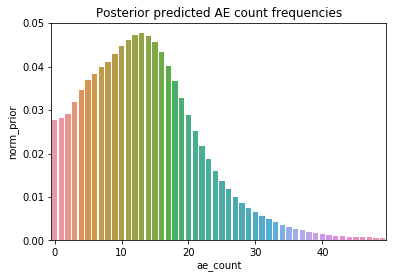

In [47]:
with model:
    ppc = pm.sample_posterior_predictive(idata, var_names=['rates', 'observations', 'reference_rate', 'underreporting'], random_seed=RANDOM_SEED)

plot_predicted_ae_frequencies(ppc, "Posterior")

In [48]:
def summarize_results(idata, unique_sites=unique_sites):
    summary_df = pd.DataFrame({'site': unique_sites,
                               'mean_ae_rate': idata.posterior['rates'].data.mean(axis=(0, 1)),
                               'std_ae_rate': idata.posterior['rates'].data.std(axis=(0, 1)),
                               'rate_tail_area': idata.posterior['underreporting'].data.mean(axis=(0,1))
                              }).merge(pd.DataFrame(data.groupby('site_number')['ae_count_cumulative'].apply(list)),
                                       left_on='site',
                                       right_index=True,
                                       how='left'
                                      )
    return summary_df

## Underreporting evaluation
The following table summarizes the posterior mean and standard deviation of the site reporting rates as well as their rate tail area under the posterior study-level distribution:

In [49]:
summarize_results(idata).sort_values('rate_tail_area').head(20)

,site,mean_ae_rate,std_ae_rate,rate_tail_area,ae_count_cumulative
29,3030,0.473701,0.216417,0.00425,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 2]"
35,3036,0.922081,0.471779,0.01250,"[0, 1, 0, 1]"
36,3037,1.330058,0.511819,0.02120,"[1, 0, 1, 3, 0]"
45,3046,1.599186,1.191997,0.03470,[0]
34,3035,2.262649,1.036725,0.05175,"[0, 3]"
31,3032,2.265597,1.030830,0.05235,"[3, 0]"
17,3018,2.627988,0.806107,0.06575,"[6, 1, 2, 0]"
38,3039,2.727528,1.125527,0.06990,"[3, 1]"
37,3038,2.865798,0.821121,0.07370,"[4, 1, 3, 2]"
1,3002,3.047176,0.606155,0.08005,"[2, 2, 1, 2, 5, 5, 5, 1]"


In [50]:
summarize_results(idata).sort_values('rate_tail_area').tail(20)

,site,mean_ae_rate,std_ae_rate,rate_tail_area,ae_count_cumulative
70,3071,22.148269,4.437367,0.77430,[23]
11,3012,21.667842,1.878398,0.77810,"[24, 31, 26, 20, 15, 15]"
121,3122,22.069505,3.247750,0.77815,"[44, 1]"
112,3113,23.045128,4.534650,0.79050,[24]
54,3055,23.462254,3.340926,0.80375,"[25, 23]"
61,3062,24.925184,2.436561,0.83375,"[37, 32, 12, 20]"
60,3061,27.269246,3.592407,0.86350,"[42, 14]"
96,3097,27.737923,3.633415,0.86845,"[39, 18]"
46,3047,28.317340,1.659186,0.88060,"[28, 42, 39, 32, 4, 32, 21, 30, 15, 42]"
67,3068,28.656487,3.690326,0.88150,"[32, 27]"


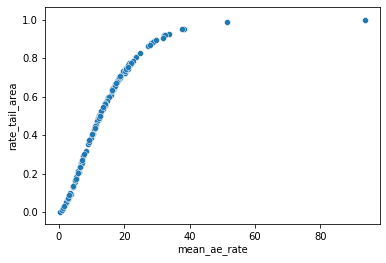

In [32]:
ax=sns.scatterplot(x='mean_ae_rate', y='rate_tail_area', data=summarize_results(idata))
plt.show()

## Model with uniform priors
To check sensitivity to the choice of priors, we can run the same analysis with wide uniform priors $\mu \sim U(0, 50)$ and $\sigma \sim U(0, 50)$:

In [14]:
with pm.Model() as model_uniform:
    mu = pm.Uniform("mu", lower=0, upper=50)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    
    rates = pm.Gamma("rates", mu=mu, sigma=sigma, shape=unique_sites.shape)
    observations = pm.Poisson("observations", mu=rates[sites_idx], observed=observed_ae)
    
    reference_rate = pm.Gamma("reference_rate", mu=mu, sigma=sigma)
    underreporting = pm.Deterministic("underreporting", reference_rate < rates)
    
    prior_checks = pm.sample_prior_predictive(samples=50, random_seed=RANDOM_SEED)

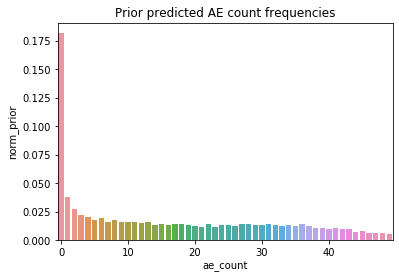

In [15]:
plot_predicted_ae_frequencies(prior_checks, "Prior")

In [16]:
with model_uniform:
    idata_uniform = pm.sample(1000, return_inferencedata=True, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [reference_rate, rates, sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


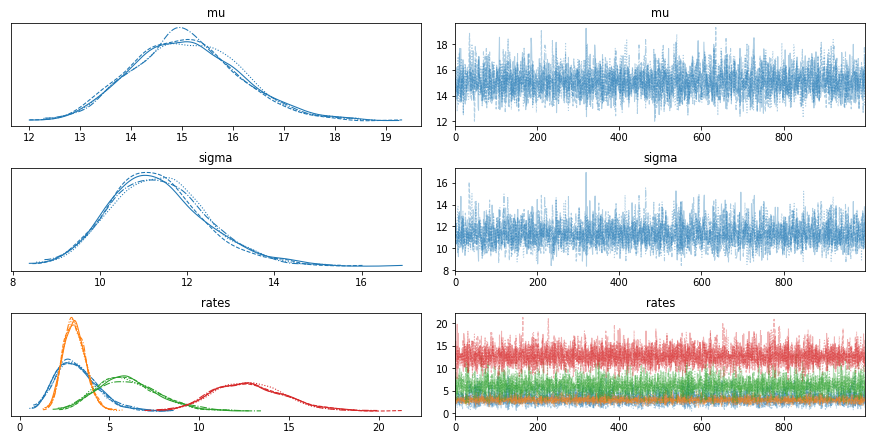

In [17]:
pm.plot_trace(idata_uniform, var_names=["mu", "sigma", "rates"], coords={"rates_dim_0": [0, 1, 2, 3]})
plt.show()

In [18]:
az.summary(idata_uniform, var_names=["mu", "sigma", "rates"], round_to=2).head(n=10)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,15.08,1.06,13.13,17.04,0.02,0.01,3362.49,2896.64,1.0
sigma,11.35,1.10,9.41,13.52,0.02,0.01,2973.48,2922.29,1.0
rates[0],3.19,1.18,1.18,5.37,0.02,0.01,5489.27,2706.78,1.0
rates[1],3.05,0.62,1.89,4.17,0.01,0.01,6508.06,2521.45,1.0
rates[2],6.04,1.71,3.11,9.34,0.02,0.02,6190.23,2755.73,1.0
rates[3],12.78,1.98,9.10,16.46,0.02,0.02,8038.37,2610.53,1.0
rates[4],9.30,2.02,5.60,13.08,0.03,0.02,5921.57,3255.18,1.0
rates[5],3.65,1.33,1.27,6.05,0.02,0.01,5839.29,2488.59,1.0
rates[6],6.05,2.28,2.18,10.23,0.03,0.02,5664.67,2549.52,1.0
rates[7],17.99,1.71,14.98,21.38,0.02,0.02,6711.12,2664.87,1.0


In [19]:
with model_uniform:
    ppc_uniform = pm.sample_posterior_predictive(idata_uniform,
                                                 var_names=['rates', 'observations', 'reference_rate', 'underreporting'],
                                                 random_seed=RANDOM_SEED)

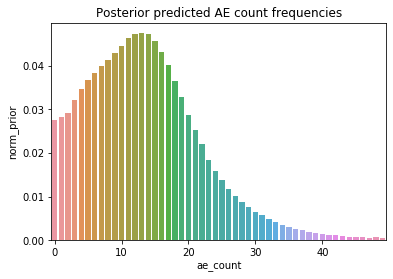

In [20]:
plot_predicted_ae_frequencies(ppc_uniform, "Posterior")

In [35]:
summarize_results(idata_uniform).sort_values('rate_tail_area').head(20)

,site,mean_ae_rate,std_ae_rate,rate_tail_area,ae_count_cumulative
29,3030,0.477346,0.217253,0.00300,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 2]"
35,3036,0.920242,0.462205,0.01200,"[0, 1, 0, 1]"
36,3037,1.317767,0.502185,0.02575,"[1, 0, 1, 3, 0]"
45,3046,1.609550,1.220536,0.03850,[0]
34,3035,2.274671,1.039737,0.05650,"[0, 3]"
31,3032,2.258359,1.027598,0.05675,"[3, 0]"
17,3018,2.627619,0.832237,0.06975,"[6, 1, 2, 0]"
38,3039,2.734650,1.125781,0.07625,"[3, 1]"
37,3038,2.859058,0.828867,0.08175,"[4, 1, 3, 2]"
1,3002,3.051233,0.618543,0.08600,"[2, 2, 1, 2, 5, 5, 5, 1]"


## Smaller trial
To see how this approach performs on smaller trials, we can retain only a fraction of the sites from the full dataset and repeat the analysis.

In [39]:
small_sites = unique_sites[:10]

small_data = data[data.site_number.isin(small_sites)]

small_sites = small_data['site_number'].values
small_observed_ae = small_data['ae_count_cumulative'].values
small_unique_sites, small_sites_idx = np.unique(small_sites, return_inverse=True)

In [40]:
len(small_data)

45

In [23]:
with pm.Model() as small_model:
    mu = pm.Exponential("mu", lam=0.1)
    sigma = pm.Exponential("sigma", lam=0.1)
    
    rates = pm.Gamma("rates", mu=mu, sigma=sigma, shape=small_unique_sites.shape)
    observations = pm.Poisson("observations", mu=rates[small_sites_idx], observed=small_observed_ae)
    
    reference_rate = pm.Gamma("reference_rate", mu=mu, sigma=sigma)
    underreporting = pm.Deterministic("underreporting", reference_rate < rates)
    
    prior_checks = pm.sample_prior_predictive(samples=50, random_seed=RANDOM_SEED)

/Users/barmazy/opt/anaconda3/lib/python3.7/site-packages/pymc3/distributions/transforms.py:221: RuntimeWarning: divide by zero encountered in log
  return np.log(x)


In [24]:
with small_model:
    small_idata = pm.sample(1000, return_inferencedata=True, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [reference_rate, rates, sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


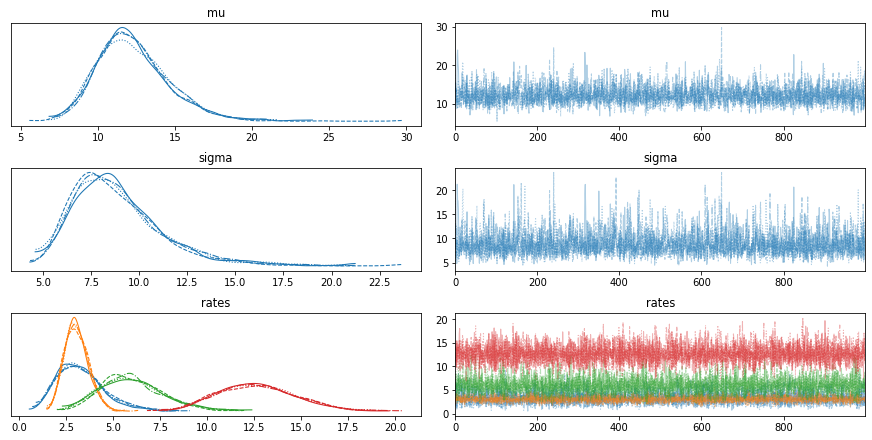

In [25]:
pm.plot_trace(small_idata, var_names=["mu", "sigma", "rates"], coords={"rates_dim_0": [0, 1, 2, 3]})
plt.show()

In [26]:
az.summary(small_idata, var_names=["mu", "sigma", "rates"], round_to=2).head(n=10)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,12.30,2.33,8.17,16.52,0.04,0.03,3498.90,2862.39,1.0
sigma,8.90,2.47,4.98,13.35,0.05,0.03,3487.99,2798.98,1.0
rates[0],3.29,1.25,1.19,5.68,0.02,0.01,6270.17,2969.51,1.0
rates[1],3.07,0.63,1.97,4.27,0.01,0.01,6820.20,2711.71,1.0
rates[2],6.00,1.68,3.04,9.26,0.02,0.02,6424.81,2750.70,1.0
rates[3],12.65,2.03,8.99,16.34,0.02,0.02,7567.15,3152.18,1.0
rates[4],9.25,2.06,5.74,13.21,0.02,0.02,7471.45,3065.36,1.0
rates[5],3.74,1.38,1.39,6.29,0.02,0.01,6232.50,3047.52,1.0
rates[6],6.05,2.25,2.05,10.13,0.03,0.02,6729.65,2554.36,1.0
rates[7],17.80,1.70,14.68,20.90,0.02,0.02,6430.40,2973.06,1.0


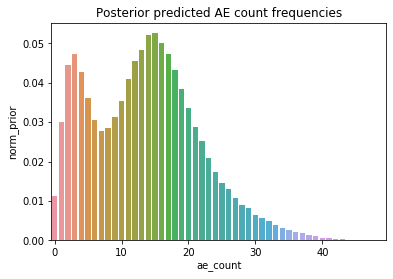

In [27]:
with small_model:
    small_ppc = pm.sample_posterior_predictive(small_idata,
                                               var_names=['rates', 'observations', 'reference_rate', 'underreporting'],
                                               random_seed=RANDOM_SEED)

plot_predicted_ae_frequencies(small_ppc, "Posterior")

### Comparison with the results obtained from the whole dataset:

In [28]:
df_comp = (summarize_results(small_idata, unique_sites=small_unique_sites)
           .sort_values('rate_tail_area')
           .merge(summarize_results(idata), on='site', how='left', suffixes=(None, '_ref'))
           .drop('ae_count_cumulative_ref', axis=1)
          )

df_comp

,site,mean_ae_rate,std_ae_rate,rate_tail_area,ae_count_cumulative,mean_ae_rate_ref,std_ae_rate_ref,rate_tail_area_ref
0,3002,3.073764,0.629972,0.11000,"[2, 2, 1, 2, 5, 5, 5, 1]",3.044453,0.619113,0.07650
1,3001,3.287786,1.247203,0.12650,"[4, 1]",3.209663,1.247433,0.08800
2,3006,3.738658,1.378297,0.14475,"[2, 4]",3.649618,1.308859,0.09675
3,3003,5.999460,1.678981,0.27125,"[7, 4]",6.048335,1.672531,0.21575
4,3007,6.047184,2.252466,0.27250,[5],6.071747,2.289255,0.20700
5,3009,6.474087,1.703627,0.30425,"[6, 6]",6.516165,1.749248,0.23550
6,3005,9.253716,2.063494,0.44550,"[12, 6]",9.356922,2.038170,0.36875
7,3015,10.602643,2.180736,0.51475,"[7, 14]",10.724011,2.225989,0.43200
8,3004,12.645778,2.029384,0.60450,"[3, 27, 8]",12.759125,1.964344,0.50825
9,3010,14.674560,0.918215,0.68500,"[21, 10, 6, 17, 10, 7, 26, 19, 18, 1, 18, 23, ...",14.704852,0.932950,0.58450


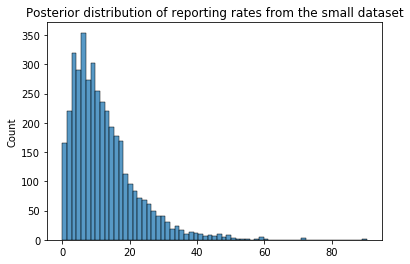

In [29]:
sns.histplot(x=small_idata.posterior['reference_rate'].data.flatten())
plt.title('Posterior distribution of reporting rates from the small dataset')
plt.show()

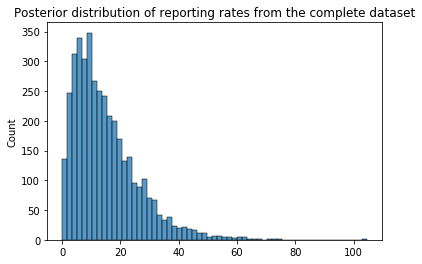

In [30]:
sns.histplot(x=idata.posterior['reference_rate'].data.flatten())
plt.title('Posterior distribution of reporting rates from the complete dataset')
plt.show()